<a href="https://colab.research.google.com/github/Fhelyp/Case_PO_Prosper/blob/main/Case%20Pr%C3%A1tico%20PO%20%7C%20Lu%C3%A3%20Fhelyp%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💡 O que é isso?

**Execução do Case Prático para PO's da ProsperTech.**

👨‍💻 Desenvolvido por [Luã Fhelyp P. Guimarães](https://www.linkedin.com/in/Fhelyp/) - [Omie](https://www.linkedin.com/company/omie)

1. [Clique aqui](https://fhelyp.notion.site/Case-Pr-tico-PO-1356c89f1f58800a903bec7db36fa91c) para acessar as **instruções** do Case Prático PO;
2. No final deste notebook, você encontrará um link para acessar o **dashboard final**, desenvolvido com os dados deste case.





---



# 💿 Configuração do ambiente

In [ ]:
# Importando bibliotecas e fazendo instalações iniciais
!pip install pandas sqlalchemy matplotlib seaborn
import sqlite3
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

# 📥 Criação e população do banco

In [ ]:
# Conectar banco
conn = sqlite3.connect('ecommerce_data.db')

# Criar tabelas
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Clientes (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        email TEXT,
        cidade TEXT
    );
''')
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Produtos (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        preco REAL,
        categoria TEXT
    );
''')
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Vendas (
        id INTEGER PRIMARY KEY,
        cliente_id INTEGER,
        produto_id INTEGER,
        data_venda DATE,
        quantidade INTEGER,
        valor_total REAL,
        FOREIGN KEY (cliente_id) REFERENCES Clientes(id),
        FOREIGN KEY (produto_id) REFERENCES Produtos(id)
    );
''')
conn.commit()
conn.close()


In [ ]:
# Popular o banco com dados fictícios
# Dados teste
clientes_data = {
    'id': [1, 2, 3],
    'nome': ['Alice', 'Bob', 'Carol'],
    'email': ['alice@example.com', 'bob@example.com', 'carol@example.com'],
    'cidade': ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte']
}
clientes_df = pd.DataFrame(clientes_data)

# Inserir dados no SQLite
conn = sqlite3.connect('ecommerce_data.db')
clientes_df.to_sql('Clientes', conn, if_exists='replace', index=False)
conn.close()


In [ ]:
# Conexão com o SQLAlchemy
engine = create_engine('sqlite:///ecommerce_data.db')

# Consulta
query = "SELECT * FROM Clientes"
clientes_df = pd.read_sql(query, engine)
clientes_df.head()


,id,nome,email,cidade
0,1,Alice,alice@example.com,São Paulo
1,2,Bob,bob@example.com,Rio de Janeiro
2,3,Carol,carol@example.com,Belo Horizonte


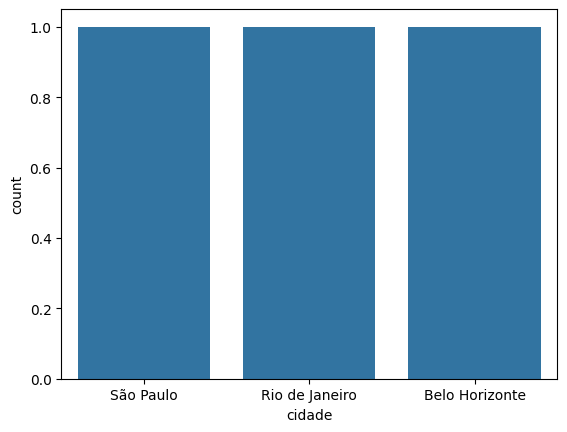

In [ ]:
# Visualização
sns.countplot(data=clientes_df, x='cidade')
plt.show()

 **📝 Nota**: Não encontrei um arquivo SQL para importar dados fictícios no banco, mas utilizei o Faker para gerar volumes de dados abaixo, e atender ao requisito do case:

> "milhares de registros"

In [ ]:
# Faker
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.6 MB/s eta 0:00:00


In [ ]:
from faker import Faker
import pandas as pd
import numpy as np
import sqlite3
import random
from datetime import datetime, timedelta

fake = Faker('pt_BR')
num_clientes = 1000
num_produtos = 500
num_vendas = 5000

# Gerar Clientes
clientes_data = {
    'id': range(1, num_clientes + 1),
    'nome': [fake.name() for _ in range(num_clientes)],
    'email': [fake.email() for _ in range(num_clientes)],
    'cidade': [fake.city() for _ in range(num_clientes)]
}
clientes_df = pd.DataFrame(clientes_data)

# Gerar Produtos
categorias = ['Eletrônicos', 'Roupas', 'Alimentos', 'Livros', 'Móveis']
produtos_data = {
    'id': range(1, num_produtos + 1),
    'nome': [fake.word().capitalize() for _ in range(num_produtos)],
    'preco': [round(fake.random_number(digits=3) + fake.random.random(), 2) for _ in range(num_produtos)],
    'categoria': [random.choice(categorias) for _ in range(num_produtos)]  # Usando random.choice para selecionar uma categoria aleatória
}
produtos_df = pd.DataFrame(produtos_data)

# Gerar Vendas
vendas_data = {
    'id': range(1, num_vendas + 1),
    'cliente_id': [fake.random_int(min=1, max=num_clientes) for _ in range(num_vendas)],
    'produto_id': [fake.random_int(min=1, max=num_produtos) for _ in range(num_vendas)],
    'data_venda': [fake.date_between(start_date='-1y', end_date='today') for _ in range(num_vendas)],
    'quantidade': [fake.random_int(min=1, max=5) for _ in range(num_vendas)],
    'valor_total': [round(fake.random_number(digits=3) + fake.random.random(), 2) * fake.random_int(min=1, max=5) for _ in range(num_vendas)]  # Corrigido para gerar o valor total da venda
}
vendas_df = pd.DataFrame(vendas_data)

# Popular tabelas
conn = sqlite3.connect('ecommerce_data.db')

clientes_df.to_sql('Clientes', conn, if_exists='replace', index=False)
produtos_df.to_sql('Produtos', conn, if_exists='replace', index=False)
vendas_df.to_sql('Vendas', conn, if_exists='replace', index=False)

conn.close()

print("Dados fictícios inseridos com sucesso!")

Dados fictícios inseridos com sucesso!


# 🔎 Consultas básicas + extração (análise inicial)

In [ ]:
#  Produtos e preços
query_produtos = """
SELECT categoria,
       COUNT(*) as total_produtos,
       ROUND(AVG(preco), 2) as preco_medio,
       MIN(preco) as preco_minimo,
       MAX(preco) as preco_maximo
FROM Produtos
GROUP BY categoria
ORDER BY total_produtos DESC;
"""

# Vendas por período
query_vendas_periodo = """
SELECT
    strftime('%Y-%m', data_venda) as mes,
    COUNT(*) as total_vendas,
    ROUND(SUM(valor_total), 2) as valor_total_vendas,
    ROUND(AVG(valor_total), 2) as ticket_medio
FROM Vendas
GROUP BY mes
ORDER BY mes;
"""

# Clientes e volume de compras
query_top_clientes = """
WITH ClientesRanking AS (
    SELECT
        c.nome,
        c.cidade,
        COUNT(v.id) as total_compras,
        ROUND(SUM(v.valor_total), 2) as valor_total_gasto,
        ROUND(AVG(v.valor_total), 2) as ticket_medio,
        DENSE_RANK() OVER (ORDER BY SUM(v.valor_total) DESC) as ranking
    FROM Clientes c
    JOIN Vendas v ON c.id = v.cliente_id
    GROUP BY c.id, c.nome, c.cidade
)
SELECT *
FROM ClientesRanking
WHERE ranking <= 10;
"""

#  Sazonalidade
query_sazonalidade = """
SELECT
    strftime('%m', data_venda) as mes,
    p.categoria,
    COUNT(*) as total_vendas,
    ROUND(SUM(v.valor_total), 2) as valor_total,
    ROUND(AVG(v.valor_total), 2) as ticket_medio
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id
GROUP BY mes, p.categoria
ORDER BY mes, p.categoria;
"""

# Executar queries
def executar_analise(query, engine, titulo):
    # Executar query
    df = pd.read_sql(query, engine)
    print(f"\n=== {titulo} ===")
    print(df)
    return df

# Printar vizualizações
engine = create_engine('sqlite:///ecommerce_data.db')

df_produtos = executar_analise(query_produtos, engine, "Análise de Produtos por Categoria")
df_vendas = executar_analise(query_vendas_periodo, engine, "Análise de Vendas por Período")
df_clientes = executar_analise(query_top_clientes, engine, "Top 10 Clientes")
df_sazonalidade = executar_analise(query_sazonalidade, engine, "Análise de Sazonalidade")


=== Análise de Produtos por Categoria ===
     categoria  total_produtos  preco_medio  preco_minimo  preco_maximo
0    Alimentos             116       504.35          1.12        998.71
1       Roupas             112       493.30          3.41        978.46
2       Livros             102       466.02          5.95        995.00
3       Móveis              92       521.39         17.03        996.45
4  Eletrônicos              78       472.85         15.62        999.98

=== Análise de Vendas por Período ===
        mes  total_vendas  valor_total_vendas  ticket_medio
0   2023-11            79           125717.23       1591.36
1   2023-12           443           685708.96       1547.88
2   2024-01           411           626458.97       1524.23
3   2024-02           394           588436.10       1493.49
4   2024-03           443           692634.38       1563.51
5   2024-04           416           614549.93       1477.28
6   2024-05           413           633471.81       1533.83
7   20

In [ ]:
# Análise de produtos
query_produtos_populares = """
WITH ProdutosVendidos AS (
    SELECT
        p.categoria,
        p.nome as produto,
        COUNT(v.id) as total_vendas,
        SUM(v.quantidade) as quantidade_total,
        ROUND(SUM(v.valor_total), 2) as receita_total,
        RANK() OVER (
            PARTITION BY p.categoria
            ORDER BY COUNT(v.id) DESC
        ) as posicao_categoria
    FROM Produtos p
    JOIN Vendas v ON p.id = v.produto_id
    GROUP BY p.categoria, p.nome
)
SELECT
    categoria,
    produto,
    total_vendas,
    quantidade_total,
    receita_total,
    'Top ' || posicao_categoria as ranking
FROM ProdutosVendidos
WHERE posicao_categoria <= 3  -- Mostra apenas os 3 mais vendidos de cada categoria
ORDER BY categoria, posicao_categoria;
"""

# Executar a query
engine = create_engine('sqlite:///ecommerce_data.db')
df_produtos_populares = pd.read_sql(query_produtos_populares, engine)

# Mostrar resultados de forma mais organizada
print("\nProdutos mais vendidos por categoria:")
for categoria in df_produtos_populares['categoria'].unique():
    print(f"\n=== {categoria} ===")
    produtos_categoria = df_produtos_populares[df_produtos_populares['categoria'] == categoria]
    print(produtos_categoria[['produto', 'total_vendas', 'quantidade_total', 'receita_total', 'ranking']].to_string(index=False))


Produtos mais vendidos por categoria:

=== Alimentos ===
produto  total_vendas  quantidade_total  receita_total ranking
Tempora            43               113       56280.13   Top 1
 Facere            28                87       42460.80   Top 2
Ducimus            27                85       40379.96   Top 3

=== Eletrônicos ===
  produto  total_vendas  quantidade_total  receita_total ranking
  Dolorem            34                94       54519.94   Top 1
    Illum            23                63       40162.39   Top 2
Doloribus            20                65       31044.79   Top 3

=== Livros ===
    produto  total_vendas  quantidade_total  receita_total ranking
     Dolore            30                89       54960.74   Top 1
  Occaecati            29                93       46024.50   Top 2
Consectetur            28                77       39692.09   Top 3

=== Móveis ===
  produto  total_vendas  quantidade_total  receita_total ranking
    Natus            41               119   

# 🕵️‍♂️ Consultas avançadas e visualização de dados

In [ ]:
# Importação

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np

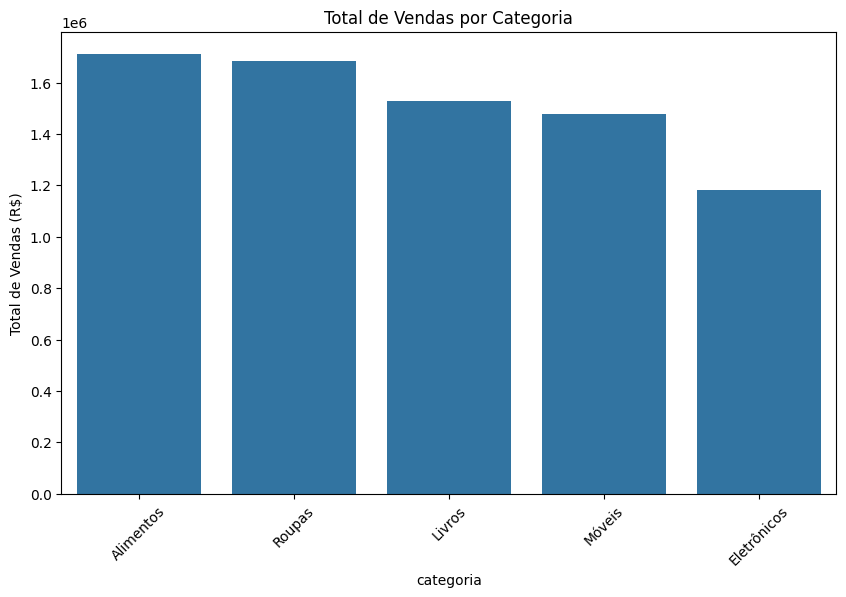

In [ ]:
# Análise: vendas/categoria
query_vendas_categoria = """
SELECT
    p.categoria,
    COUNT(*) as num_vendas,
    ROUND(SUM(v.valor_total), 2) as total_vendas
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id
GROUP BY p.categoria
ORDER BY total_vendas DESC;
"""

df_vendas_cat = pd.read_sql(query_vendas_categoria, engine)

# Gráfico de vendas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_vendas_cat, x='categoria', y='total_vendas')
plt.title('Total de Vendas por Categoria')
plt.xticks(rotation=45)
plt.ylabel('Total de Vendas (R$)')
plt.show()

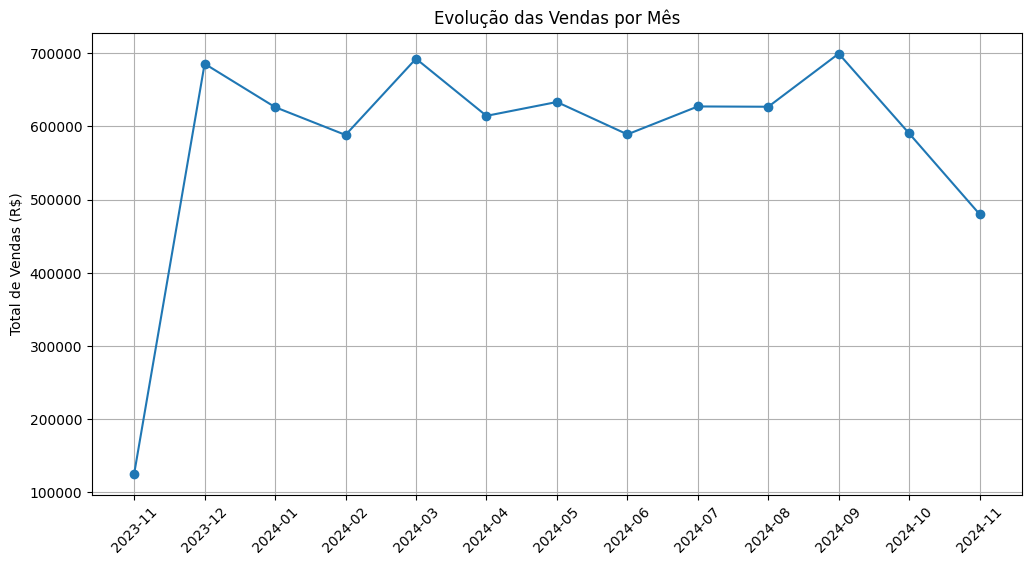

In [ ]:
# Análise: Vendas ao longo do tempo
query_vendas_tempo = """
SELECT
    strftime('%Y-%m', data_venda) as mes,
    COUNT(*) as num_vendas,
    ROUND(SUM(valor_total), 2) as total_vendas
FROM Vendas
GROUP BY mes
ORDER BY mes;
"""

df_vendas_tempo = pd.read_sql(query_vendas_tempo, engine)

# Gráfico de linha --- vendas por mês
plt.figure(figsize=(12, 6))
plt.plot(df_vendas_tempo['mes'], df_vendas_tempo['total_vendas'], marker='o')
plt.title('Evolução das Vendas por Mês')
plt.xticks(rotation=45)
plt.ylabel('Total de Vendas (R$)')
plt.grid(True)
plt.show()

<ipython-input-13-38fc1be38a57>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cidades, x='cidade', y='total_vendas', palette='viridis')


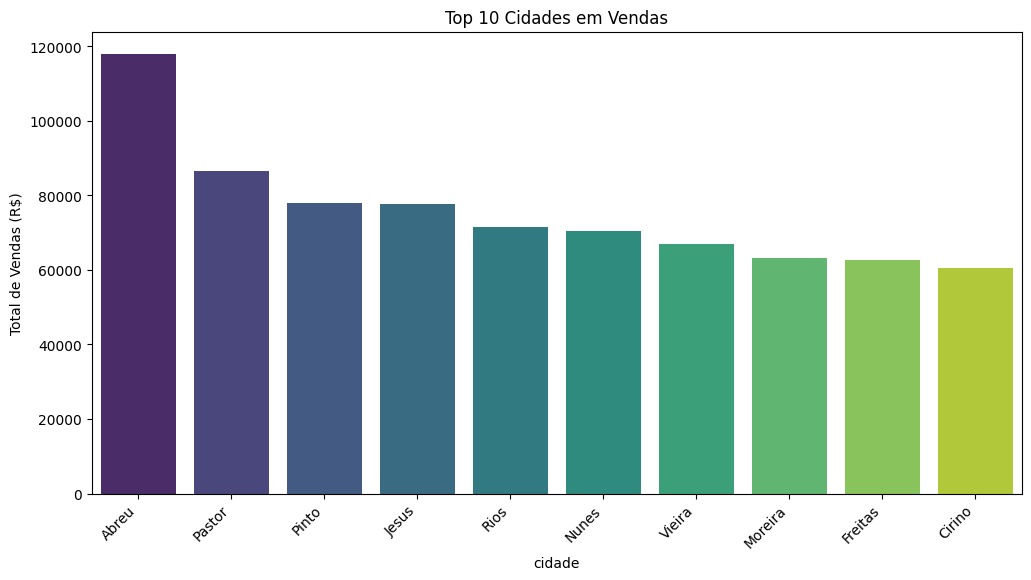

In [ ]:
# Análise: Cidades que mais compram
query_cidades = """
SELECT
    c.cidade,
    COUNT(*) as num_vendas,
    ROUND(SUM(v.valor_total), 2) as total_vendas
FROM Vendas v
JOIN Clientes c ON v.cliente_id = c.id
GROUP BY c.cidade
ORDER BY total_vendas DESC
LIMIT 10;
"""

df_cidades = pd.read_sql(query_cidades, engine)

# Gráfico das cidades
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cidades, x='cidade', y='total_vendas', palette='viridis')
plt.title('Top 10 Cidades em Vendas')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total de Vendas (R$)')
plt.show()

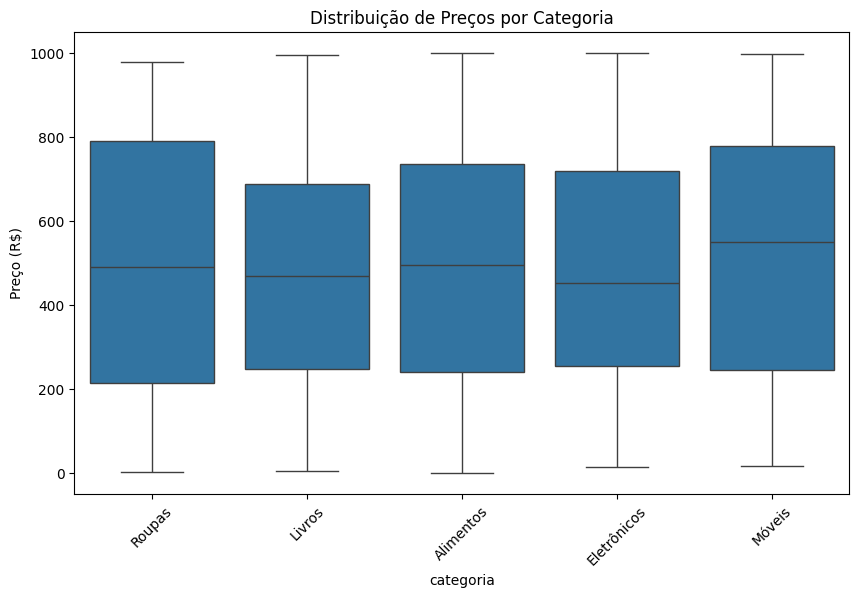

In [ ]:
# Análise: Distribuição de preços/categoria
query_precos = """
SELECT categoria, preco
FROM Produtos;
"""

df_precos = pd.read_sql(query_precos, engine)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_precos, x='categoria', y='preco')
plt.title('Distribuição de Preços por Categoria')
plt.xticks(rotation=45)
plt.ylabel('Preço (R$)')
plt.show()

<ipython-input-15-2fd5dd28bbb4>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dia_semana, x='dia_semana', y='num_vendas', palette='Set3')


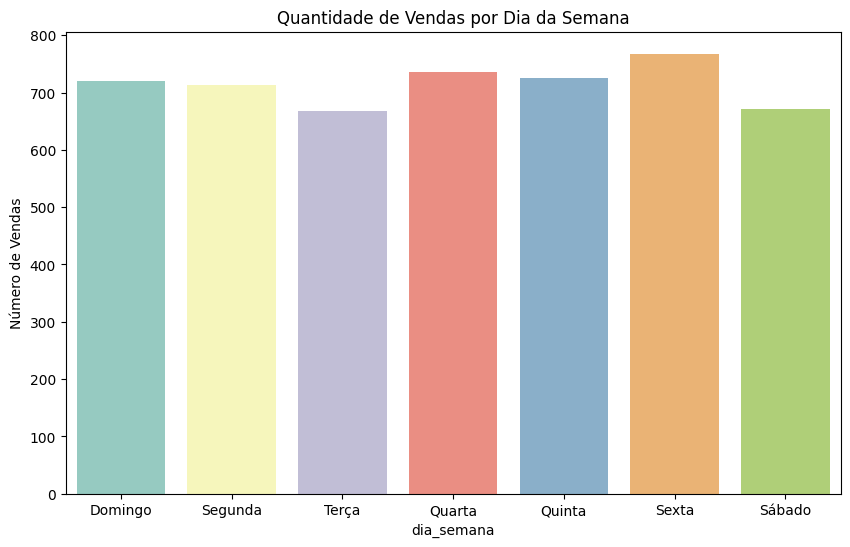

In [ ]:
# Análise: Quantidade de vendas/dia da semana
query_dia_semana = """
SELECT
    CASE cast(strftime('%w', data_venda) as integer)
        WHEN 0 THEN 'Domingo'
        WHEN 1 THEN 'Segunda'
        WHEN 2 THEN 'Terça'
        WHEN 3 THEN 'Quarta'
        WHEN 4 THEN 'Quinta'
        WHEN 5 THEN 'Sexta'
        WHEN 6 THEN 'Sábado'
    END as dia_semana,
    COUNT(*) as num_vendas
FROM Vendas
GROUP BY dia_semana
ORDER BY cast(strftime('%w', data_venda) as integer);
"""

df_dia_semana = pd.read_sql(query_dia_semana, engine)

# Gráfico de vendas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dia_semana, x='dia_semana', y='num_vendas', palette='Set3')
plt.title('Quantidade de Vendas por Dia da Semana')
plt.ylabel('Número de Vendas')
plt.show()

In [ ]:
# Insights
total_vendas = df_vendas_cat['total_vendas'].sum()
categoria_mais_vendida = df_vendas_cat.iloc[0]['categoria']
cidade_mais_compra = df_cidades.iloc[0]['cidade']

print("👉 Insights:\n")
print(f"Total de vendas: R$ {total_vendas:,.2f}")
print(f"Categoria que mais vendeu: {categoria_mais_vendida}")
print(f"Cidade que mais compra: {cidade_mais_compra}")

👉 Insights:

Total de vendas: R$ 7,580,761.48
Categoria que mais vendeu: Alimentos
Cidade que mais compra: Abreu


<ipython-input-17-8e8020555ad2>:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(


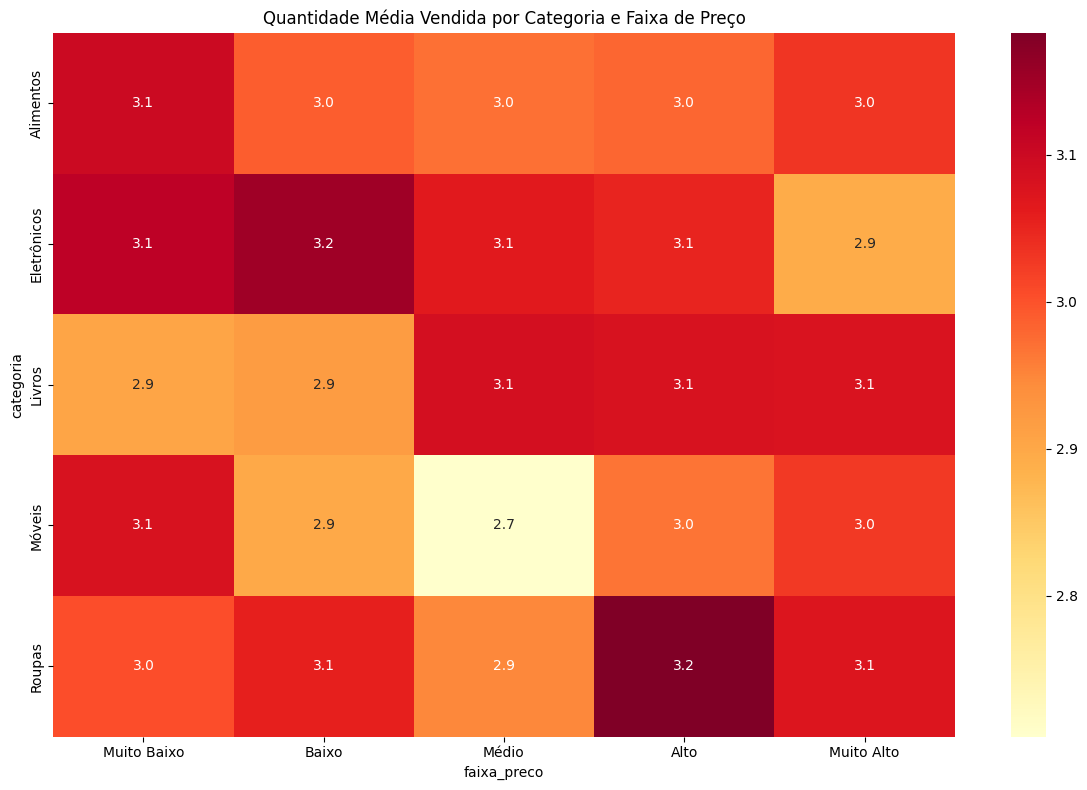

In [ ]:
# Correlação entre preço e quantidade vendida
query_preco_qtd = """
SELECT
    p.preco,
    v.quantidade,
    p.categoria
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id;
"""
df_preco_qtd = pd.read_sql(query_preco_qtd, engine)

# Cria faixas de preço para visualização
df_preco_qtd['faixa_preco'] = pd.qcut(df_preco_qtd['preco'], q=5, labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])

# Heatmap
plt.figure(figsize=(12, 8))
heatmap_data = pd.pivot_table(
    df_preco_qtd,
    values='quantidade',
    index='categoria',
    columns='faixa_preco',
    aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Quantidade Média Vendida por Categoria e Faixa de Preço')
plt.tight_layout()
plt.show()

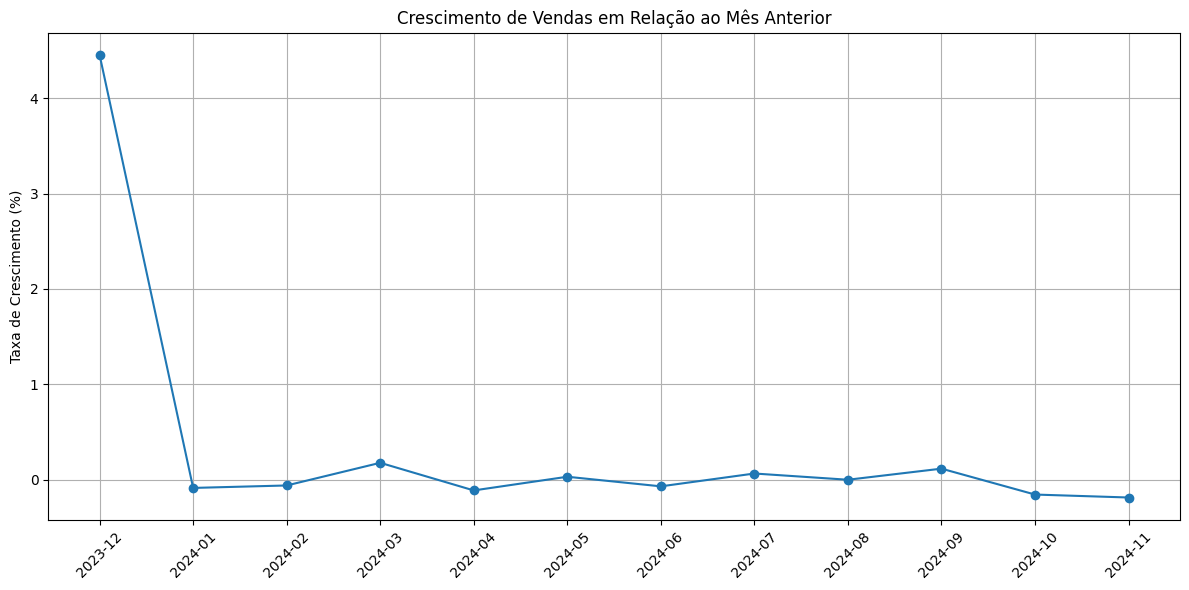

In [ ]:
# 3. Análise comparativa de períodos
query_periodos = """
WITH vendas_mensais AS (
    SELECT
        strftime('%Y-%m', data_venda) as mes,
        SUM(valor_total) as valor_total,
        COUNT(*) as num_vendas,
        AVG(quantidade) as qtd_media
    FROM Vendas
    GROUP BY mes
)
SELECT
    mes,
    valor_total,
    num_vendas,
    qtd_media,
    valor_total / LAG(valor_total) OVER (ORDER BY mes) - 1 as crescimento_mes_anterior
FROM vendas_mensais
ORDER BY mes;
"""
df_periodos = pd.read_sql(query_periodos, engine)

# Gráfico de crescimento mês a mês
plt.figure(figsize=(12, 6))
plt.plot(df_periodos['mes'], df_periodos['crescimento_mes_anterior'], marker='o', linestyle='-')
plt.title('Crescimento de Vendas em Relação ao Mês Anterior')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylabel('Taxa de Crescimento (%)')
plt.tight_layout()
plt.show()

# 4. Padrões de compra por hora do dia
query_hora = """
SELECT
    CAST(strftime('%H', data_venda) AS INTEGER) as hora,
    COUNT(*) as num_vendas,
    AVG(valor_total) as ticket_medio
FROM Vendas
GROUP BY hora
ORDER BY hora;
"""
df_hora = pd.read_sql(query_hora, engine)

In [ ]:
# 2. Estatísticas descritivas por categoria
query_stats = """
SELECT
    p.categoria,
    v.valor_total,
    v.quantidade,
    p.preco
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id;
"""
df_stats = pd.read_sql(query_stats, engine)

# Calcular estatísticas
stats_categoria = df_stats.groupby('categoria').agg({
    'valor_total': ['mean', 'median', 'std', 'count'],
    'quantidade': ['mean', 'median', 'std'],
    'preco': ['mean', 'median', 'std']
}).round(2)

print("\nEstatísticas Descritivas por Categoria:")
print(stats_categoria)


Estatísticas Descritivas por Categoria:
            valor_total                         quantidade               \
                   mean   median      std count       mean median   std   
categoria                                                                 
Alimentos       1534.22  1194.04  1195.78  1116       3.01    3.0  1.42   
Eletrônicos     1586.86  1330.47  1192.37   745       3.06    3.0  1.41   
Livros          1497.55  1225.65  1196.38  1020       3.00    3.0  1.42   
Móveis          1538.20  1253.70  1213.18   960       2.95    3.0  1.43   
Roupas          1451.42  1036.80  1195.61  1159       3.05    3.0  1.41   

              preco                  
               mean  median     std  
categoria                            
Alimentos    504.46  502.40  292.33  
Eletrônicos  488.80  472.71  280.49  
Livros       456.96  436.28  277.16  
Móveis       518.64  544.88  292.58  
Roupas       495.73  493.55  290.15  


In [ ]:
# Consolidados
print("Descobertas: \n")
#print(f"1. Horário com mais vendas: {df_hora.loc[df_hora['num_vendas'].idxmax(), 'hora']}h")
# print(f"2. Horário com maior ticket médio: {df_hora.loc[df_hora['ticket_medio'].idxmax(), 'hora']}h")

# Maior e menor crescimento
df_periodos['crescimento_mes_anterior'] = df_periodos['crescimento_mes_anterior'].fillna(0)
melhor_mes = df_periodos.loc[df_periodos['crescimento_mes_anterior'].idxmax(), 'mes']
pior_mes = df_periodos.loc[df_periodos['crescimento_mes_anterior'].idxmin(), 'mes']

print(f"3. Mês com maior crescimento: {melhor_mes}")
print(f"4. Mês com menor crescimento: {pior_mes}")

# Categorias com maior e menor variação de preço
cv_precos = df_stats.groupby('categoria')['preco'].agg(lambda x: x.std()/x.mean()).sort_values(ascending=False)
print(f"5. Categoria com maior variação de preço: {cv_precos.index[0]}")
print(f"6. Categoria com menor variação de preço: {cv_precos.index[-1]}")

Descobertas: 

3. Mês com maior crescimento: 2023-12
4. Mês com menor crescimento: 2024-11
5. Categoria com maior variação de preço: Livros
6. Categoria com menor variação de preço: Móveis


# 🚮 Limpeza, analise de performance e geração de relatórios

In [ ]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for its plotting functions and styles
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Limpando dados
# Vou juntar tudo em uma query só pra ficar mais fácil
query_dados = """
    SELECT
        v.*,
        c.nome as cliente_nome,
        c.cidade as cliente_cidade,
        p.nome as produto_nome,
        p.categoria as produto_categoria,
        p.preco as preco_unitario
    FROM Vendas v
    JOIN Clientes c ON v.cliente_id = c.id
    JOIN Produtos p ON v.produto_id = p.id
"""

# Carregando dados em DataFrame
df = pd.read_sql(query_dados, engine)

# Vizualização rápida
print("\nPrimeiras linhas dos dados:")
print(df.head())
print("\nInformações sobre os dados:")
print(df.info())


Primeiras linhas dos dados:
   id  cliente_id  produto_id  data_venda  quantidade  valor_total  \
0   1         481         392  2024-01-28           5      1243.23   
1   2          27         197  2023-12-18           5      2851.30   
2   3         470         200  2024-05-26           1       591.96   
3   4         819         471  2024-10-17           4        67.32   
4   5         637         394  2024-07-21           4      3536.60   

          cliente_nome         cliente_cidade produto_nome produto_categoria  \
0          Lucca Alves               Ferreira        Illum       Eletrônicos   
1      Isadora da Rosa      da Paz de da Mota   Voluptatum         Alimentos   
2        Ana Liz Souza  Montenegro das Flores        Culpa            Roupas   
3      Augusto Costela         Silva do Galho       Beatae       Eletrônicos   
4  João Miguel Pereira    Barros de Aparecida         Ipsa            Móveis   

   preco_unitario  
0          965.86  
1          839.21  
2        

In [ ]:
# Convertendo coluna de data para datetime
df['data_venda'] = pd.to_datetime(df['data_venda'])

# Removendo valores nulos (se tiver)
print(f"Linhas antes de remover nulos: {len(df)}")
df = df.dropna()
print(f"Linhas depois de remover nulos: {len(df)}")
# Removendo duplicatas (se tiver)
df = df.drop_duplicates()
print(f"Linhas depois de remover duplicatas: {len(df)}")

Linhas antes de remover nulos: 5000
Linhas depois de remover nulos: 5000
Linhas depois de remover duplicatas: 5000


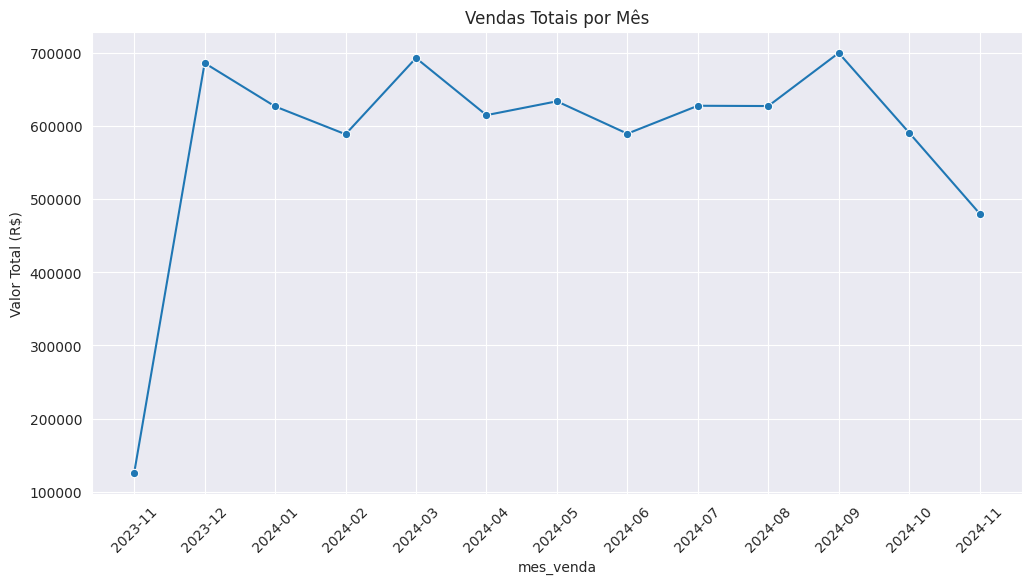

In [ ]:
# Criando informações
# Separando data
df['mes_venda'] = df['data_venda'].dt.strftime('%Y-%m')
df['dia_semana'] = df['data_venda'].dt.day_name()  # dia da semana
df['hora_venda'] = df['data_venda'].dt.hour

# Calculando margem de lucro (vou considerar que o custo é 70% do preço, só pra testar)
df['custo_estimado'] = df['preco_unitario'] * 0.7
df['margem_lucro'] = df['valor_total'] - (df['custo_estimado'] * df['quantidade'])
df['margem_percentual'] = (df['margem_lucro'] / df['valor_total']) * 100

# Calculando por cliente
metricas_cliente = df.groupby('cliente_id').agg({
    'data_venda': lambda x: (x.max() - x.min()).days,  # dias entre primeira e última compra
    'id': 'count',  # número de compras
    'valor_total': 'sum'  # valor total gasto
}).reset_index()

# Renomear as colunas
metricas_cliente.columns = ['cliente_id', 'dias_entre_compras', 'total_compras', 'valor_total_compras']

# Tempo médio entre compras
metricas_cliente['tempo_medio_entre_compras'] = metricas_cliente['dias_entre_compras'] / metricas_cliente['total_compras']

# Unificando as métricas no DataFrame
df = df.merge(metricas_cliente[['cliente_id', 'tempo_medio_entre_compras']],
              on='cliente_id', how='left')

# Configurar o estilo dos gráficos
#plt.style.use('seaborn') # Remove this line, seaborn styles are automatically applied when using seaborn plotting functions.
sns.set_style('darkgrid') # Instead, use seaborn's set_style to apply its themes, like 'darkgrid', 'whitegrid', 'ticks', etc.
# or sns.set_theme(style="darkgrid") #  Alternative using seaborn.set_theme to apply theme

# Vendas por mês
plt.figure(figsize=(12, 6))
vendas_mes = df.groupby('mes_venda')['valor_total'].sum().reset_index()
# Use seaborn's lineplot for a more visually appealing and integrated plot with the theme.
sns.lineplot(x='mes_venda', y='valor_total', data=vendas_mes, marker='o')
plt.title('Vendas Totais por Mês')
plt.xticks(rotation=45)
plt.ylabel('Valor Total (R$)')
plt.grid(True)
plt.show()

In [ ]:
# Salvar resultados am arquivos
# Criando uma pasta para os arquivos
import os
if not os.path.exists('resultados'):
    os.makedirs('resultados')

# Salvando em CSV
df.to_csv('resultados/dados_tratados.csv', index=False)
metricas_cliente.to_csv('resultados/metricas_clientes.csv', index=False)

# Salvando em XLSX (várias abas)
with pd.ExcelWriter('resultados/relatorio_ecommerce.xlsx') as writer:
    df.to_excel(writer, sheet_name='Dados_Completos', index=False)
    metricas_cliente.to_excel(writer, sheet_name='Metricas_Clientes', index=False)
    vendas_mes.to_excel(writer, sheet_name='Vendas_por_Mes', index=False)

print("\n✅ Confira os arquivos na pasta 'resultados'")


✅ Confira os arquivos na pasta 'resultados'


In [ ]:
# Estatísticas
print("\nDescobertas")
print(f"- Total de vendas: R$ {df['valor_total'].sum():,.2f}")
print(f"- Média de margem de lucro: {df['margem_percentual'].mean():.1f}%")
print(f"- Cliente que mais comprou: {df.groupby('cliente_nome')['valor_total'].sum().idxmax()}")


Descobertas
- Total de vendas: R$ 7,580,761.48
- Média de margem de lucro: -458.1%
- Cliente que mais comprou: Luiza da Luz


# 📤 Exportação Google Sheets > Integração Looker Studio

In [ ]:
# Instalar bibliotecas necessárias
!pip install --upgrade gspread gspread-dataframe

# Autenticação no Google
from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe

auth.authenticate_user()
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# Criar uma nova planilha no Google Sheets
spreadsheet = gc.create('Resultados_Ecommerce')

# Selecionar a primeira aba e enviar o DataFrame principal
worksheet1 = spreadsheet.get_worksheet(0)
worksheet1.update_title("Dados_Completos")  # Renomear a aba
set_with_dataframe(worksheet1, df)

# Criar e enviar a aba de Métricas de Clientes
worksheet2 = spreadsheet.add_worksheet(title="Metricas_Clientes", rows="100", cols="20")
set_with_dataframe(worksheet2, metricas_cliente)

# Criar e enviar a aba de Vendas por Mês
worksheet3 = spreadsheet.add_worksheet(title="Vendas_por_Mes", rows="100", cols="20")
set_with_dataframe(worksheet3, vendas_mes)

print(f"Planilha criada com sucesso! Acesse aqui: {spreadsheet.url}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2
  Attempting uninstall: gspread-dataframe
    Found existing installation: gspread-dataframe 3.3.1
    Uninstalling gspread-dataframe-3.3.1:
      Successfully uninstalled gspread-dataframe-3.3.1
Planilha criada com sucesso! Acesse aqui: https://docs.google.com/spreadsheets/d/1WLQsUvGfX-hOcKM7SEZ1WOIT5qwc0Yr0jkfVFz-wjYU


📌 Link ACESSÍVEL, da planilha gerada na etapa acima 👆 -> https://docs.google.com/spreadsheets/d/1WLQsUvGfX-hOcKM7SEZ1WOIT5qwc0Yr0jkfVFz-wjYU/edit?usp=sha

# 📊 Dashboard (Relatório interativo)

👉 **[Clique aqui](https://lookerstudio.google.com/reporting/3546ee55-9c2a-4c93-b961-5d5864cae957)** para acessar o **Dashboard** desenvolvido no Looker Studio (ferramenta de Business Intelligence).